In [1]:
%run PVModel_functions.ipynb

In [2]:
%run PVsystem_filterfunction_jack-may.ipynb

In [3]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

mod_names = 'LG', 'Panasonic', 'Can270', 'Can275', 'HanQPlus', 'HanQPeak', 'MissionSolar', 'Jinko'
mettablename =  'dbo.SNLA_Met_DataOut'

In [4]:
for mod_name in mod_names:
    
    
   #Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
    mod_info = pd.read_excel('module_coefficients.xlsx')
    mod_info.index = mod_info['Manufacturer']
    del mod_info['Manufacturer']
    #defines the specific module given the previous user input and module coefficients file
    module = mod_info[mod_name]
    systablename = module['table_name']
    start = '2020-01-01 00:00:00-07:00'
     #module['start']
    end = '2021-01-01 00:00:00-07:00'
    #module['end']
    
    #Import sys & met databases & merge into one df
    df = sys_met_data(mettablename, systablename, start, end)
    initial = len(df)
    
    #Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
    sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
    edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
    edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
    
    #Calculate effective irradiance and cell temperature
    sapm_par = sapm_param(edf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.Temp_C_Avg, df.WS_ms_Mean, 
                   edf['am_abs'], edf['aoi'], module)

    sapm_tcell = sapm_par['tcell'].to_frame()
    eff_irr  = sapm_par['eff_irr'].to_frame()
    temp_irr = pd.merge(sapm_tcell,eff_irr, how = 'inner', left_index=True, right_index=True)
    df = df.merge(temp_irr, how='inner', left_index=True, right_index=True)
    df = df[~df.index.duplicated(keep='first')]
    
    #Filter out pole shading for Can275 and HanQPlus
    shade_list = ['Can270', 'HanQPlus']
    if mod_name in shade_list:
        shade_start = '2020-10-06 00:00:00-07:00'
        shade_end = '2020-11-02 00:00:00-07:00'
        shask = (df.index > shade_start) & (df.index <= shade_end)
        df = df.loc[~shask]
    
    
    #Filter and Mask Data 
    
    #Apply physical Filters
    df = simple_filter(df, 'eff_irr', lower=50, upper=1200, apply=True)
    df = simple_filter(df, 'tcell', lower=-40, upper=100, apply=True)
    
    
    ##### Filter out the data points with a certain ratio of current to irradiance
    string_is ='str_1_i', 'str_2_i', 'str_3_i', 'str_4_i'
    ratio_names = 'ratio str_1_i to eff_irr', 'ratio str_2_i to eff_irr', 'ratio str_3_i to eff_irr', 'ratio str_4_i to eff_irr'
    for string_i in string_is:
        df['ratio' + ' ' + string_i + ' ' 'to eff_irr'] = df[module[string_i]]/df['eff_irr'] 
    for ratio_name in ratio_names:
        df = simple_filter(df, ratio_name, lower=module['ratio_lower'], upper=module['ratio_upper'], apply=True)
    final = len(df)
    perc_filtered = (1-(final/initial))*100
    
    #Generate a results dataframe and add measured values
    results = meas_val(df[module['str_1_v']],df[module['str_1_i']]).to_frame()
    results['Str_2'] = meas_val(df[module['str_2_v']],df[module['str_2_i']])
    results['Str_3'] = meas_val(df[module['str_3_v']],df[module['str_3_i']])
    results['Str_4'] = meas_val(df[module['str_4_v']],df[module['str_4_i']])
    results = results.resample('H').mean()
    results.rename(columns = { 0 : 'Str_1'}, inplace = True)
    
    
    #read in SAM data from the spreadsheet containing all SAM results for entire time period of system
    sam_data = pd.read_excel('SAM_results.xlsx', sheet_name = [mod_name])
    sam_data = sam_data[mod_name]
    sam_data.index = sam_data['Time']
    sam_data.index = pd.DatetimeIndex(sam_data.index)
    del sam_data['Time']
    sam_data.rename(columns = {mod_name : 'SAM'}, inplace = True)
    sam_data = sam_data.loc[start:end, :]
    results ['SAM'] = sam_data['SAM']#.resample('M').mean()
    
    
    #Calcualte SAPM results and add to df
    dc = sapm(df['eff_irr'], df['tcell'], module)
    results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])#.resample('M').mean()
   
    
    
    #Calculate PVWatts results and add to df
    results['PVWatts'] = (pvwatts(POA_eff = df['eff_irr'], cell_temp = df['tcell'], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'],
                                                 temp_ref=25.0))#.resample('M').mean()
    
   #Calculate CEC results and add to df
    cec_param = pvlib.pvsystem.calcparams_cec( df['eff_irr'], df['tcell'], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
    cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
    results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])#.resample('M').mean()
    
    
   #Calculate Desoto results and add to df
    ds_param = pvlib.pvsystem.calcparams_desoto(df['eff_irr'], df['tcell'], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
    ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
    results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])#.resample('M').mean()
    
    #Calculte PVSystem results and add to df
    pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['eff_irr'],df['tcell'], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
    pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4], method = 'newton')
    results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])#.resample('M').mean()
    
    #Import matrix of measurement data
    measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
    matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
    matrix.columns = ['temperature', 'irradiance', 'p_mp']
    # calculate efficiency from power
    matrix = matrix.eval('eta = p_mp / irradiance')
    eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
    matrix.eta /= eta_stc.values
    # just keep the columns that are needed
    matrix = matrix[['irradiance', 'temperature', 'eta']]
    
    
    #Calculate ADR results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
    adr_eff = adr(df['eff_irr'], df['tcell'], *popt)
    adr_p = (df['eff_irr']/1000) * (adr_eff) * (module['Power']) *12
    results['ADR'] = adr_p.resample('H').mean()
    
    
   #Calculate Heydenreich results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
    hey_eff = heydenreich(df['eff_irr'], df['tcell'], *popt)
    hey_p = (df['eff_irr']/1000) * (hey_eff) * (module['Power']) *12
    results['Heydenreich'] = hey_p.resample('H').mean()
    
    
    #Calculate MotherPV results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
    mother_eff = motherpv(df['eff_irr'], df['tcell'], *popt)
    mother_p = (df['eff_irr']/1000) * (mother_eff) * (module['Power']) * 12
    results['Mother'] = mother_p.resample('H').mean()
    
    
   #Calculate PVGIS results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
    pvgis_eff = pvgis(df['eff_irr'], df['tcell'], *popt)
    pvgis_p = (df['eff_irr']/1000) * (pvgis_eff) * (module['Power']) *12
    results['PVGIS'] = pvgis_p.resample('H').mean()
    
    
    #Calculate MPM5 results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
    mpm5_eff = mpm5(df['eff_irr'], df['tcell'], *popt)
    mpm5_p = (df['eff_irr']/1000) * (mpm5_eff) * (module['Power']) *12
    results['MPM5'] = mpm5_p.resample('H').mean()
    
    
    #Calculate MPM6 results and add to df
    popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
    mpm6_eff = mpm6(df['eff_irr'], df['tcell'], *popt)
    mpm6_p = (df['eff_irr']/1000) * (mpm6_eff) * (module['Power']) *12
    results['MPM6'] = mpm6_p.resample('H').mean()
    
   #Aligns SAM results with other results since SAM results has 0's in between days instead of NaNs
    mask = np.isnan(results['Str_1'])
    results = results.mask(mask, np.nan)
    
    #Statistical Sig3 filter
    results, mask = stat_sigma_test(results, deviation = 3, apply=True)
    results=results.astype(float)
    
    results.to_csv(mod_name + '.csv')
    
    #Begin Error Calculations
    measureds = ['Str_1', 'Str_2', 'Str_3', 'Str_4']
    models = ['SAM', 'SAPM',  'ADR', 'Heydenreich', 'Mother', 'PVGIS', 'MPM5', 'MPM6','PVWatts', 'CEC', 'Desoto', 'PVSyst']
    
    #calculate absolute differences
    ad = abs(results['Str_1']-results['SAM']).to_frame()
    ad.rename(columns = { 0 : 'SAM Str_1'}, inplace = True)
    ad.index = results.index
    for model in models:
        for measured in measureds:
            ad[model + ' ' + measured] = abs(results[measured]-results[model])

        
    #calculate absolute percentage differences
    apd = 100*abs((results['SAM']-results['Str_1'])/results['Str_1']).to_frame()
    apd.rename(columns = { 0 : 'SAM Str_1'}, inplace = True)
    apd.index = results.index
    for model in models:
        for measured in measureds:
            apd[model + ' ' + measured] = 100* abs((results[measured]-results[model])/results[measured])
            
    # Organize values into mape frame to be plotted
    sammape = (apd.iloc[:, [0,1,2,3]].mean(axis=1)).to_frame()
    sammape['Model']='SAM'
    sapmmape = apd.iloc[:, [4,5,6,7]].mean(axis=1).to_frame()
    sapmmape['Model']='SAPM'
    adrmape = apd.iloc[:, [8,9,10,11]].mean(axis=1).to_frame()
    adrmape['Model']='ADR'
    heymape = apd.iloc[:, [12,13,14,15]].mean(axis=1).to_frame()
    heymape['Model']='HEY'
    mothermape = apd.iloc[:, [16,17,18,19]].mean(axis=1).to_frame()
    mothermape['Model']='MOT'
    pvgismape = apd.iloc[:, [20,21,22,23]].mean(axis=1).to_frame()
    pvgismape['Model']='PVG'
    mpm5mape = apd.iloc[:, [24,25,26,27]].mean(axis=1).to_frame()
    mpm5mape['Model']='MPM5'
    mpm6mape = apd.iloc[:, [28,29,30,31]].mean(axis=1).to_frame()
    mpm6mape['Model']='MPM6'
    pvwattsmape = apd.iloc[:, [32,33,34,35]].mean(axis=1).to_frame()
    pvwattsmape['Model']='PVW'
    cecmape = apd.iloc[:, [36,37,38,39]].mean(axis=1).to_frame()
    cecmape['Model']='CEC'
    desotomape = apd.iloc[:, [40,41,42,43]].mean(axis=1).to_frame()
    desotomape['Model']='DES'
    pvsystmape = apd.iloc[:, [44,45,46,47]].mean(axis=1).to_frame()
    pvsystmape['Model']='PVS'

    mapes = [sammape,sapmmape,adrmape,heymape,mothermape,pvgismape,mpm5mape,mpm6mape,pvwattsmape,cecmape,desotomape,pvsystmape]
    mape = pd.concat(mapes)
    mape.rename(columns = { 0 : 'MAPE'}, inplace = True)
    mape.to_csv(mod_name + '_mape.csv')
    
    
    #Organize vlues into nmbe to be plotted
    samnmbe = ((((ad.iloc[:, [0,1,2,3]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    samnmbe['Model']='SAM'
    sapmnmbe = ((((ad.iloc[:, [4,5,6,7]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    sapmnmbe['Model']='SAPM'
    adrnmbe = ((((ad.iloc[:, [8,9,10,11]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    adrnmbe['Model']='ADR'
    heynmbe = ((((ad.iloc[:, [12,13,14,15]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    heynmbe['Model']='HEY'
    mothernmbe = ((((ad.iloc[:, [16,17,18,19]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    mothernmbe['Model']='MOT'
    pvgisnmbe = ((((ad.iloc[:, [20,21,22,23]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    pvgisnmbe['Model']='PVG'
    mpm5nmbe = ((((ad.iloc[:, [24,25,26,27]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    mpm5nmbe['Model']='MPM5'
    mpm6nmbe = ((((ad.iloc[:, [28,29,30,31]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    mpm6nmbe['Model']='MPM6'
    pvwattsnmbe = ((((ad.iloc[:, [32,33,34,35]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    pvwattsnmbe['Model']='PVW'
    cecnmbe = ((((ad.iloc[:, [36,37,38,39]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    cecnmbe['Model']='CEC'
    desotonmbe = ((((ad.iloc[:, [40,41,42,43]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    desotonmbe['Model']='DES'
    pvsystnmbe = ((((ad.iloc[:, [44,45,46,47]].sum(axis=1))/len(ad))/results.iloc[:, [0,1,2,3]].mean(axis=1))*100).to_frame()
    pvsystnmbe['Model']='PVS'


    nmbes = [samnmbe, sapmnmbe, adrnmbe, heynmbe, mothernmbe, pvgisnmbe, mpm5nmbe, 
            mpm6nmbe, pvwattsnmbe, cecnmbe, desotonmbe, pvsystnmbe]
    nmbe = pd.concat(nmbes)
    nmbe.rename(columns = { 0 : 'NMBE'}, inplace = True)
    nmbe.to_csv(mod_name + '_nmbe.csv')

Text(0.5, 1.0, 'Jinko')

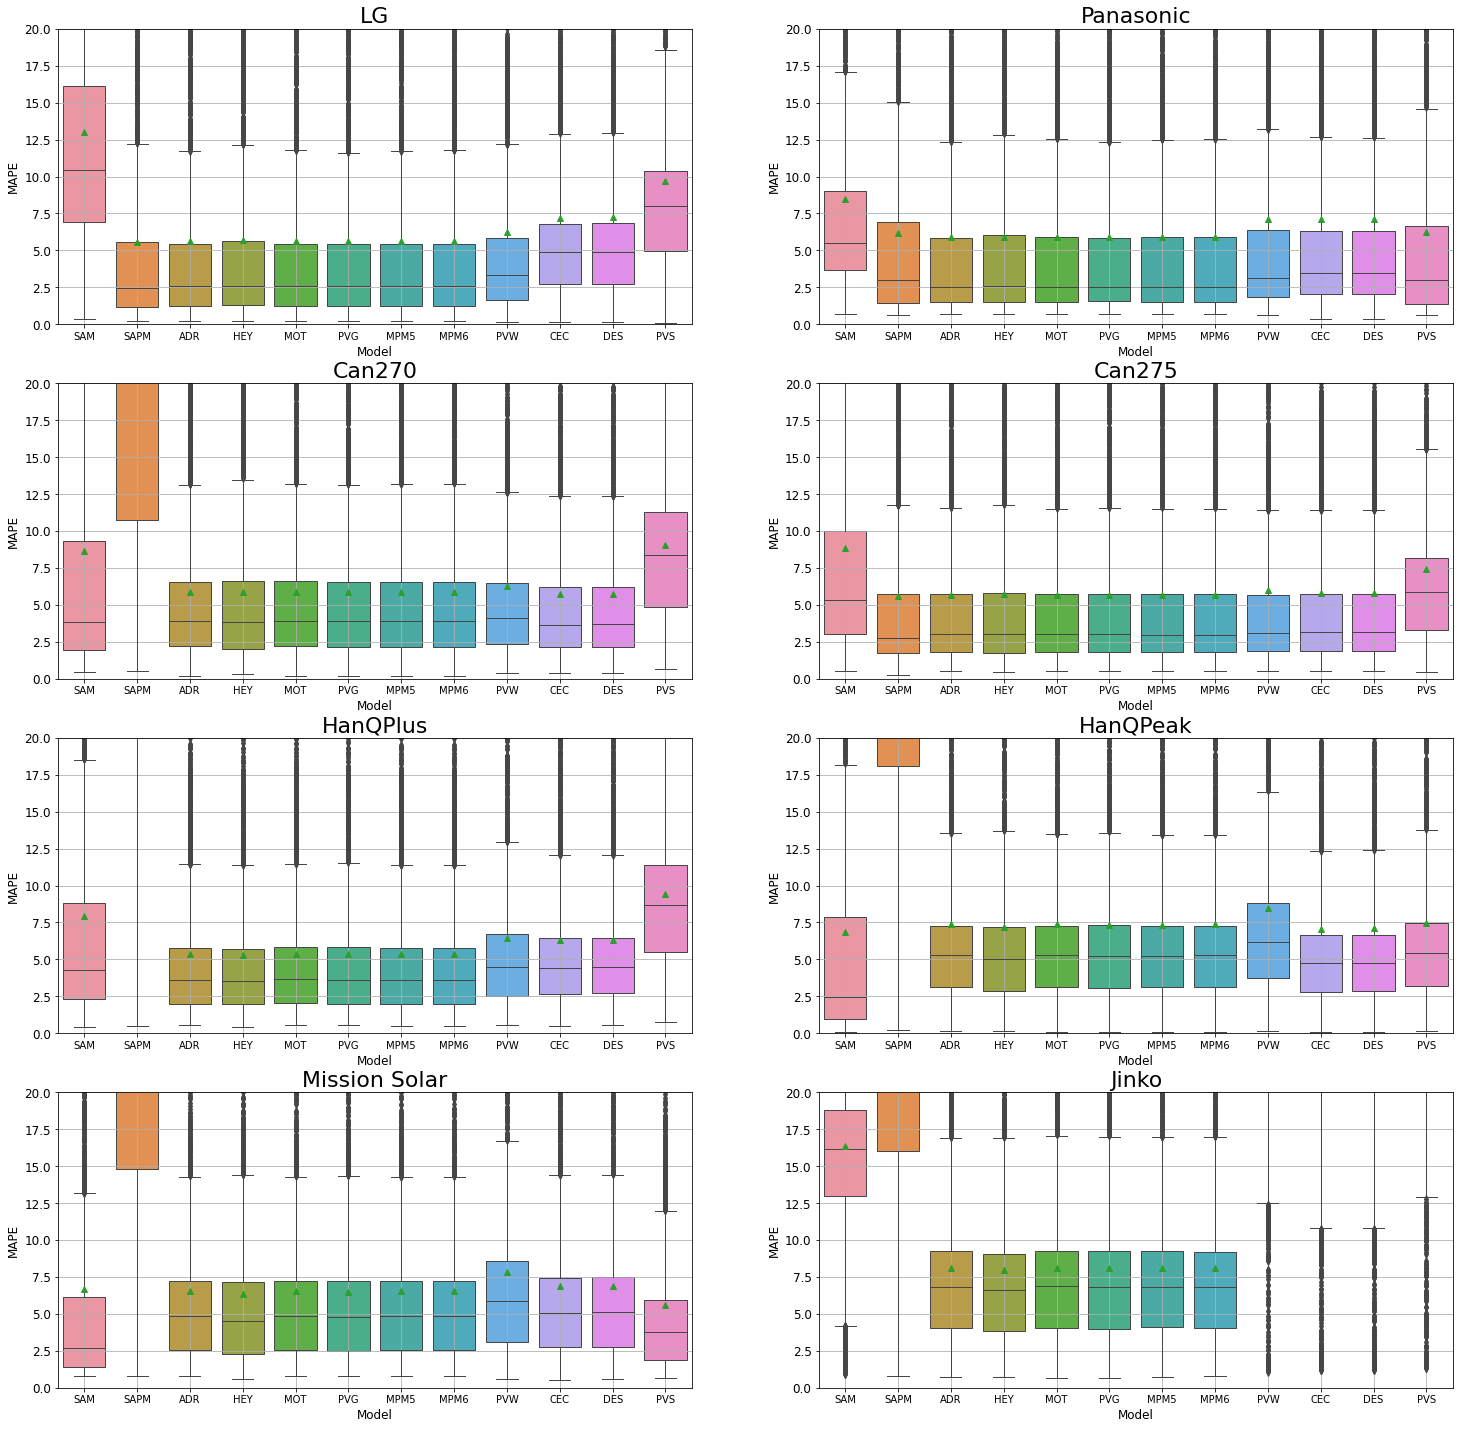

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))#, sharex = 'all', sharey = 'all')
mape = pd.read_csv('LG_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True,ax = axes[0,0])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('LG')
mape = pd.read_csv('Panasonic_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[0,1])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('Panasonic')
mape = pd.read_csv('Can270_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[1,0])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('Can270')
mape = pd.read_csv('Can275_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[1,1])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('Can275')
mape = pd.read_csv('HanQPlus_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[2,0])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('HanQPlus')
mape = pd.read_csv('HanQPeak_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[2,1])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('HanQPeak')
mape = pd.read_csv('MissionSolar_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[3,0])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('Mission Solar')
mape = pd.read_csv('Jinko_mape.csv')
ax = sns.boxplot(x = 'Model', y = 'MAPE', data = mape, showmeans=True, ax = axes[3,1])
ax.set_ylim([0,20])
ax.grid(True)
ax.set_title('Jinko')

Text(0.5, 1.0, 'Jinko')

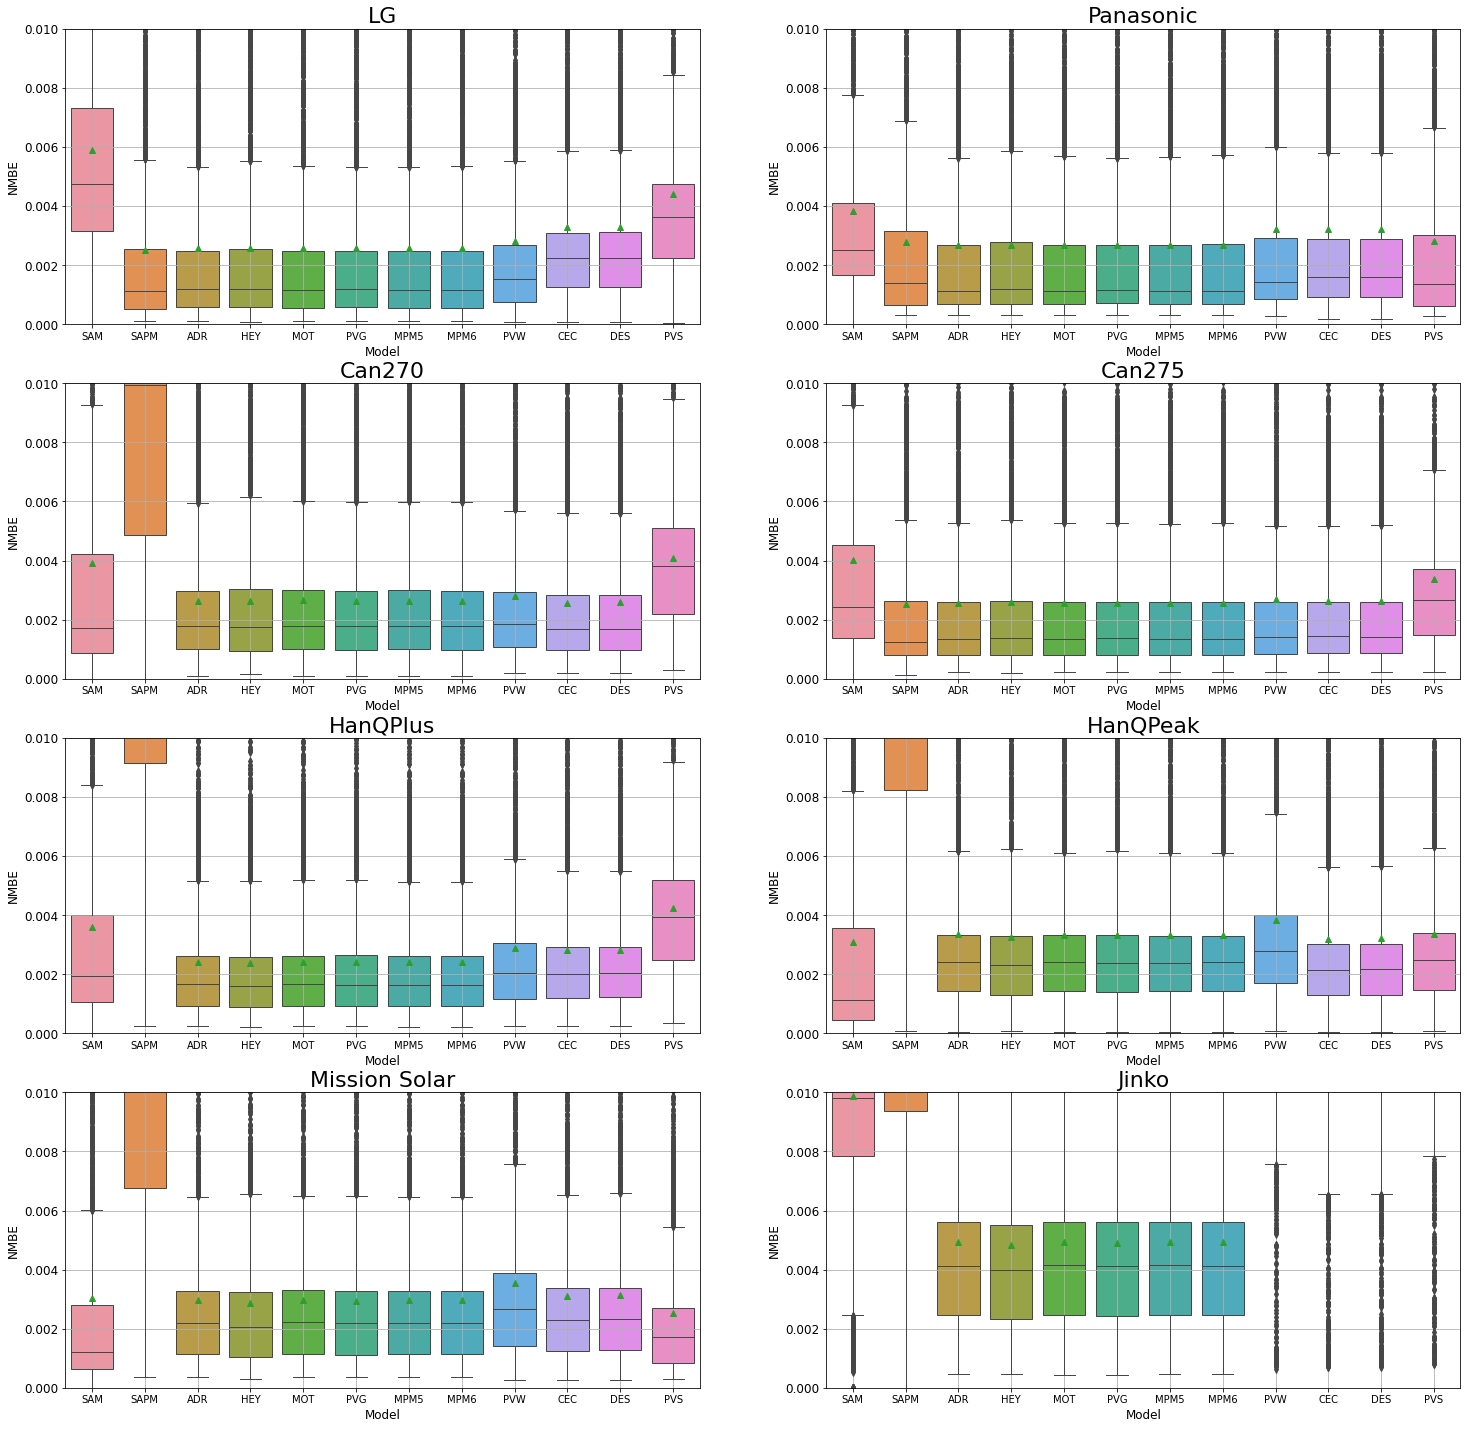

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))#, sharex = 'all', sharey = 'all')
nmbe = pd.read_csv('LG_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True,ax = axes[0,0])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('LG')
nmbe = pd.read_csv('Panasonic_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[0,1])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('Panasonic')
nmbe = pd.read_csv('Can270_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[1,0])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('Can270')
nmbe = pd.read_csv('Can275_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[1,1])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('Can275')
nmbe = pd.read_csv('HanQPlus_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[2,0])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('HanQPlus')
nmbe = pd.read_csv('HanQPeak_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[2,1])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('HanQPeak')
nmbe = pd.read_csv('MissionSolar_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[3,0])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('Mission Solar')
nmbe = pd.read_csv('Jinko_nmbe.csv')
ax = sns.boxplot(x = 'Model', y = 'NMBE', data = nmbe, showmeans=True, ax = axes[3,1])
ax.set_ylim([0,0.01])
ax.grid(True)
ax.set_title('Jinko')